In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

## Dataset preparation

### Set parameters

In [7]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "./dataset_4/training"
val_path = "./dataset_4/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

Found 17150 files belonging to 3 classes.
Found 3262 files belonging to 3 classes.


In [9]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


### Test set

In [11]:
with tf.device("CPU"):
    AUTOTUNE = tf.data.AUTOTUNE
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [12]:
print(len(validation_dataset))
print(len(test_dataset))

51
51


## Model building

In [13]:
def build_vgg16(dropout_num=0.4):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(dropout_num))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_num))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_num))
    model.add(Dense(3, activation='softmax'))  
    
    return model

In [14]:
with tf.device("GPU"):
    model = build_vgg16()

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [15]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn1_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [16]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-24 09:18:18.999729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-24 09:18:20.242450: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


536/536 [==============================] - 110s 197ms/step - loss: 1.2216 - accuracy: 0.3590 - val_loss: 1.0975 - val_accuracy: 0.3558
Epoch 2/30
536/536 [==============================] - 103s 193ms/step - loss: 1.0940 - accuracy: 0.3813 - val_loss: 1.0977 - val_accuracy: 0.3521
Epoch 3/30
536/536 [==============================] - 103s 192ms/step - loss: 1.0819 - accuracy: 0.4030 - val_loss: 1.0981 - val_accuracy: 0.3442
Epoch 4/30
536/536 [==============================] - 103s 192ms/step - loss: 1.0642 - accuracy: 0.4306 - val_loss: 1.0992 - val_accuracy: 0.3184
Epoch 5/30
536/536 [==============================] - 103s 192ms/step - loss: 1.0223 - accuracy: 0.4711 - val_loss: 1.0943 - val_accuracy: 0.3767
Epoch 6/30
536/536 [==============================] - 103s 192ms/step - loss: 0.9537 - accuracy: 0.5136 - val_loss: 1.0913 - val_accuracy: 0.4166
Epoch 7/30
536/536 [==============================] - 103s 192ms/step - loss: 0.8855 - accuracy: 0.5612 - val_loss: 1.0833 - val_accura

In [ ]:
model.save('./models/cnn1_14epoch.h5')

### Training evaluation

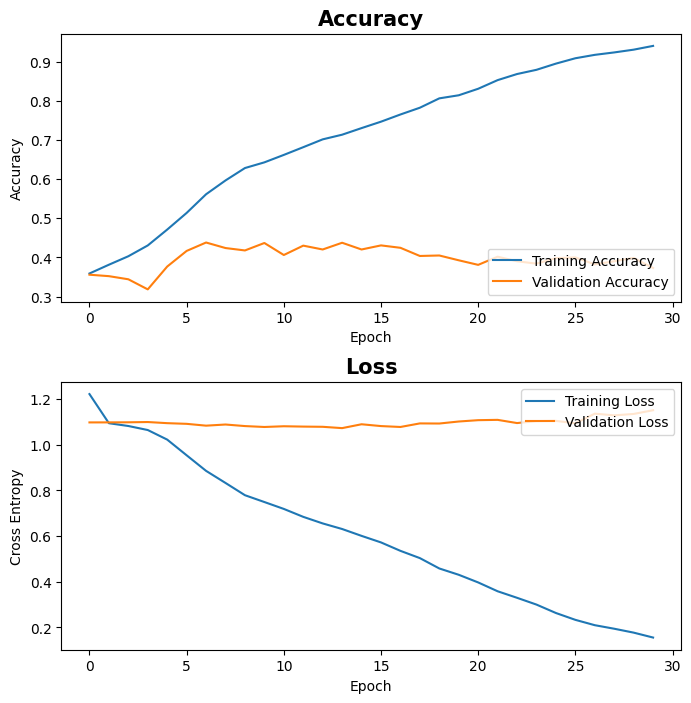

In [17]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

## Testing

In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [19]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

51/51 [==============================] - 3s 56ms/step - loss: 1.1476 - accuracy: 0.3952


{'loss': 1.1476444005966187, 'accuracy': 0.3952205777168274}

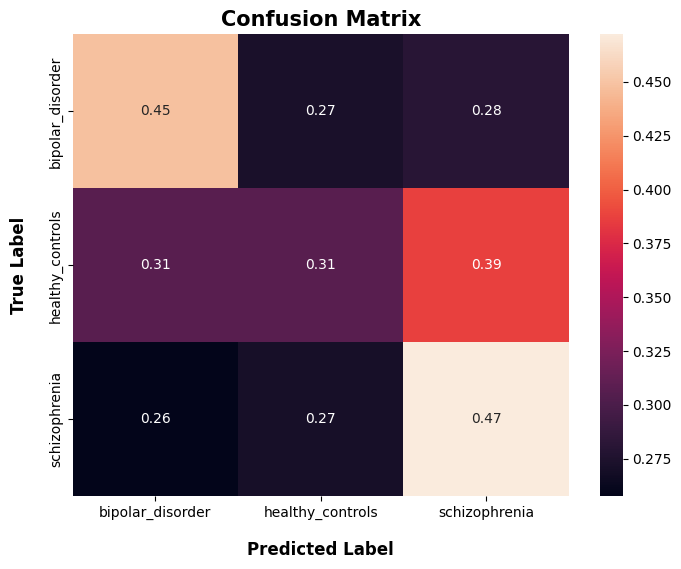

In [21]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN4_cm.png')
plt.show()

In [22]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.3952205777168274
Precision: 0.4073319015207786
Sensitivity: 0.3946078431372549
Specificity: 0.7044268065496211
